# Analysis Walkthrough: Supervised Classification with Bank Churn Data

This post provides a walkthrough demonstrating how to use the `sklearn` package in Python to tune and evaluate multiple supervised (machine learning) classification methods to predict whether bank customers will close their account. The dataset comes from a past [Kaggle competition](https://www.kaggle.com/competitions/playground-series-s4e1/data) and contains several variables, including credit score, gender, and age.

Code to produce this blog post can be found in [this](https://github.com/trgrimm/churn_analysis) GitHub repository.

# Data description

Data for this analysis comes from a previous [Kaggle playground competition](https://www.kaggle.com/competitions/playground-series-s4e1/data) titled "Binary Classification with a Bank Churn Dataset".

Bank churn, which is also known as customer attrition, is when customers end their relationship with the bank (close their accounts). Predicting churn is essential to allow the bank to take action to retain customers. The cost of acquiring a new customer is almost always higher than retaining an existing customer[^1].


**Analysis Goal:** Predict the probability that a customer `Exited` (probability of churn).

Train and test datsets are provided by Kaggle, and we want to minimize the area under the curve (AUC) of the [receiver operating characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) (ROC) curve, which is also known as the "ROC AUC score".

For this analysis, I'll walk through the following steps:
1. Exploratory data analysis
2. Model building (tuning and evaluation)
3. Prediction on new data

[^1]: https://www.forbes.com/councils/forbesbusinesscouncil/2022/12/12/customer-retention-versus-customer-acquisition/

# Exploratory data analysis (EDA)

For this analysis, we will be looking exclusively at the training dataset provided by Kaggle until we make our final predictions on the testing data. This mimics a real-life scenario where the future "new" data a model will be used on is not available until after model training, tuning, and selection.

First, we import necessary functions, load in the data, and evaluate the structure of the training dataset:

In [2]:
# Import necessary libraries/functions

# Data wrangling and computation
import pandas as pd
import numpy as np
# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn import model_selection
import sklearn.metrics as metrics
# Plotting
import matplotlib.pyplot as plt
from plotnine import ggplot, aes, facet_wrap, geom_histogram, labs
import seaborn as sns


In [6]:
# Load in train and test sets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
# Look at the first few rows of the training data
train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [4]:
# Check column types, see if any rows have null values
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [5]:
# Check how many missing values are in the training data
train.apply(lambda x: x.isna().sum())

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

There are no null or missing values. We also have the following predictor variables (features): 

**Categorical**
* `Geography`: customer's country of residence (France, Spain, or Germany)
* `Gender`: customer's gender (Male or Female)

**Quantitative**
* `CreditScore`: customer's credit score (numerical score)
* `Age`: customer's age (years)
* `Tenure`: number of years a customer has had an account with the bank
* `Balance`: customer's account balance
* `NumOfProducts`: number of bank products used by the customer (e.g., savings account, credit card)
* `EstimatedSalary`: customer's estimated salary


**Logical**
* `HasCrCard`: whether the customer has a credit card (1 = yes, 0 = no)
* `IsActiveMember`: whether the customer is an active member (1 = yes, 0 = no)

**Miscellaneous** (not useful)
* `id`: Row number
* `CustomerID`: unique identifier for each customer
* `Surname`: customer's last name

And the target (response) variable we want to predict: `Exited`.

In [6]:
# Basic summary statistics for each column in train
train.drop(columns=['id', 'CustomerId', 'Surname']).describe()


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


From the summary statistics, we see that overall churn is about 21% (about 21% of people exited).

To get an idea of the differences in values of each variable for those who closed their accounts and for those who did not, we can group by `Exited` and compute the means and standard deviations across various categories:

In [7]:
# Look at means and standard deviations of different variables for the people that closed their accounts and for those who did not
train.drop(columns = ['id', 'CustomerId', 'Surname', 'Geography', 'Gender']).groupby('Exited').agg(['mean', 'std']).round(2)

CreditScore           Age       Tenure         Balance            \
              mean    std   mean   std   mean   std      mean       std   
Exited                                                                    
0           657.59  79.79  36.56  8.15   5.05  2.80  51255.81  62189.98   
1           652.22  81.14  43.96  9.00   4.91  2.83  71209.98  62646.69   

       NumOfProducts       HasCrCard       IsActiveMember        \
                mean   std      mean   std           mean   std   
Exited                                                            
0               1.62  0.49      0.76  0.43           0.55  0.50   
1               1.33  0.66      0.74  0.44           0.29  0.46   

       EstimatedSalary            
                  mean       std  
Exited                            
0            112084.29  50214.66  
1            114402.50  50542.03

In general, most of the variables have similar values between customers with `Exited` = 1 and customers with `Exited` = 0. However, the average age is slightly higher for those with `Exited` = 1, and `IsActiveMember` is higher for customers who did not close their accounts (55% for `Exited` = 0) than for those who did (29% for `Exited` = 1), indicating that people may be more likely to close their account if they are not an active member.

To further explore this data, let's create some histograms of each variable with a different color for the customers with `Exited` = 1 and `Exited` = 0.

/Users/taylorgrimm/Documents/Professional/python_stuff/.venv/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 114'. Pick better value with 'binwidth'.


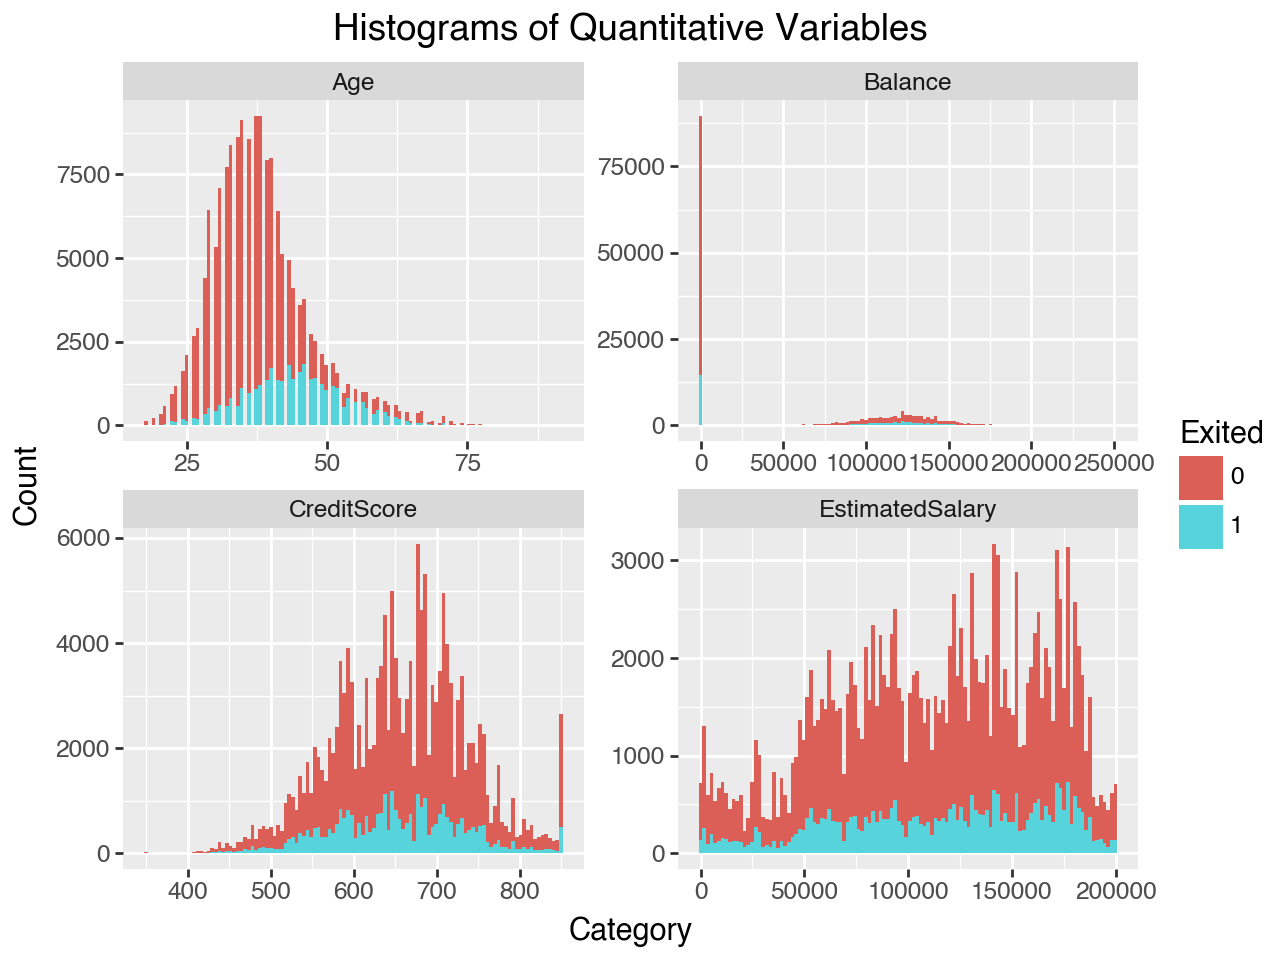

In [9]:
# Make a df for plotting, change "Exited" to a "category" type to assist with plotting
train_plot = train.astype({'Exited': 'category'})

# Plot quantitative variables
(
    # Reshape the data to facilitate plotting with ggplot
    pd.melt(train_plot[['CreditScore', 'Age' ,'Balance', 'EstimatedSalary', 'Exited']], id_vars = 'Exited')
    >> ggplot() +
        geom_histogram(aes('value', fill = 'Exited')) +
        facet_wrap('variable', scales = 'free') +
        labs(x = 'Category', y = 'Count', title = 'Histograms of Quantitative Variables')
)

Let's make a plot of the correlation matrix for the 6 continuous quantitative predictor variables:

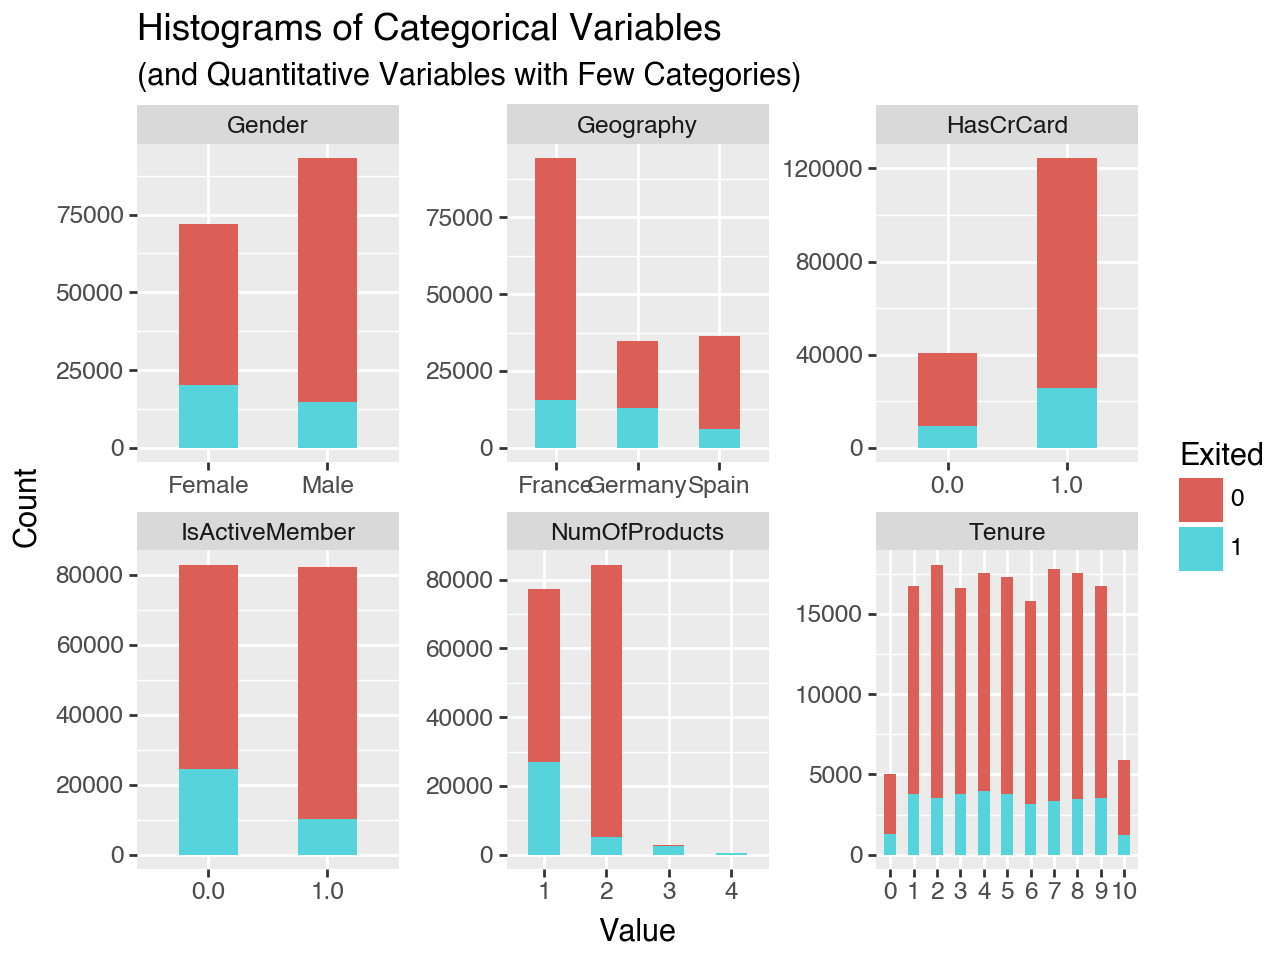

In [10]:
# Plot categorical variables and quantitative variables with few categories (NumOfProducts, Tenure)
(
    pd.melt(train_plot[['Gender', 'Geography', 'HasCrCard', 'IsActiveMember', 'NumOfProducts', 'Exited', 'Tenure']], id_vars = 'Exited')
    >> ggplot() +
        geom_histogram(aes('value', fill = 'Exited'), binwidth = .5) +
        facet_wrap('variable', scales = 'free') +
        labs(x = 'Value', y = 'Count', title = 'Histograms of Categorical Variables', subtitle = '(and Quantitative Variables with Few Categories)')
)

In general, the shapes of the distributions of the variables is similar. However, there is a noticeable difference in `Age`, where the majority of customers with `Exited` = 0 tend to be younger, while the majority of customers with `Exited` = 1 tend to be older, which is similar to what was observed based on the summary statistics.

Now, let's look at correlations between the quantitative predictors to determine if any substantial multicollinearity is present:

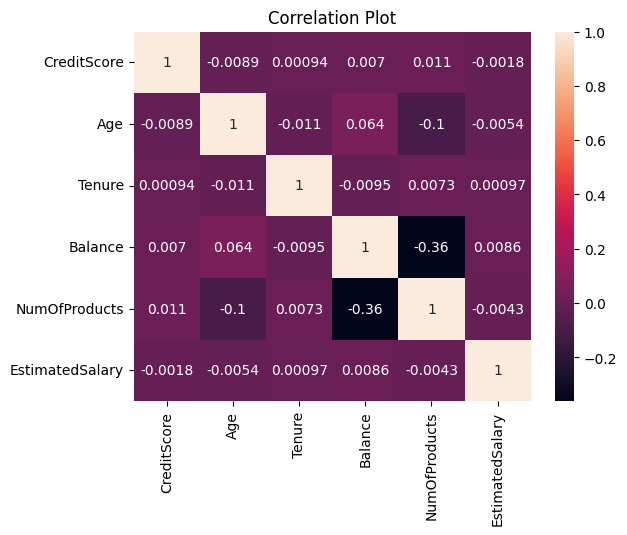

In [11]:
sns.heatmap(train.drop(columns = ['id', 'CustomerId', 'Surname', 'Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'Exited']).corr(), annot = True)
plt.title('Correlation Plot')
plt.show()

Most of the predictors are uncorrelated with one another, but there appears to be a weak linear relationship between `Balance` and `NumOfProducts`.

# Feature engineering

A common step in many machine learning projects is to "engineer" new features. The goal is to create new predictor columns that will provide better model predictions of the target variable, `Exited`. Often, new features are created using domain expertise.

A naive approach to feature engineering is to simply augment the feature (predictor) matrix with polynomials of the quantitative variables. For simplicity, I'll only add the following:

* a squared `EstimatedSalary` column, denoted `EstimatedSalary2`
* a squared `CreditScore` column, denoted `CreditScore2`
* a squared `Balance` column, denoted `Balance2`

In [8]:
train['EstimatedSalary2'] = train['EstimatedSalary']**2
train['CreditScore2'] = train['CreditScore']**2
train['Balance2'] = train['Balance']**2

# The new variables are now part of the training data
train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,EstimatedSalary2,CreditScore2,Balance2
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,3.292409e+10,446224,0.000000e+00
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,2.450597e+09,393129,0.000000e+00
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,3.417569e+10,459684,0.000000e+00
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,7.150542e+09,337561,2.216601e+10
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,2.270696e+08,512656,0.000000e+00


# Model building, tuning, and selection


We will evaluate the performance of 5 different classification methods on predicting `Exited` in the training data:
* logistic regression (LR)
* k-nearest neighbors (KNN)
* support vector machine (SVM)
* random forest (RF)
* extreme gradient boosting (XGBoost)

Below, each method will be tuned for optimal performance, and its performance will be evaluated in terms of ROC AUC. Then, the overall performance of each model will be compared, and the best model will be selected for final predictions on the testing data.

## Set up the training data

Perform the following:

Create the predictor `X_train` matrix:
* apply one hot encoding to the categorical variables
* for SVM, center and scale the numerical predictors

Create the target `y_train` vector.

In [9]:
# Import additional functions for preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [10]:
# Creating the X_train matrix:

# Remove columns that are not predictors
X_train = train.drop(columns=['id', 'CustomerId','Surname', 'Exited'])

# Separate out the categorical columns for one hot encoding
X_train_encoding = X_train[['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']]

# Create a matrix of the one hot encoded categorical columns
encoder = OneHotEncoder(sparse_output = False)
X_train_encoded = encoder.fit_transform(X_train_encoding)

# Check the names of the columns that were created via one hot encoding
encoder.get_feature_names_out()

# The encoded matrix is currently a numpy array. Change this to a data frame
X_train_encoded = pd.DataFrame(X_train_encoded, columns = encoder.get_feature_names_out())

# Combine the numerical columns with the categorical columns to create a single X_train data frame
X_train = pd.concat([X_train.drop(columns = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']).reset_index(drop = True), X_train_encoded], axis = 1)

# Make sure everything looks correct
X_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,EstimatedSalary2,CreditScore2,Balance2,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,HasCrCard_0.0,HasCrCard_1.0,IsActiveMember_0.0,IsActiveMember_1.0
0,668,33.0,3,0.00,2,181449.97,3.292409e+10,446224,0.000000e+00,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,627,33.0,1,0.00,2,49503.50,2.450597e+09,393129,0.000000e+00,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
2,678,40.0,10,0.00,2,184866.69,3.417569e+10,459684,0.000000e+00,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,581,34.0,2,148882.54,1,84560.88,7.150542e+09,337561,2.216601e+10,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,716,33.0,5,0.00,2,15068.83,2.270696e+08,512656,0.000000e+00,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0


In [11]:
y_train = train['Exited']

## Logistic Regression (LR)

In [16]:
X_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,EstimatedSalary2,CreditScore2,Balance2,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,HasCrCard_0.0,HasCrCard_1.0,IsActiveMember_0.0,IsActiveMember_1.0
0,668,33.0,3,0.00,2,181449.97,3.292409e+10,446224,0.000000e+00,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,627,33.0,1,0.00,2,49503.50,2.450597e+09,393129,0.000000e+00,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
2,678,40.0,10,0.00,2,184866.69,3.417569e+10,459684,0.000000e+00,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,581,34.0,2,148882.54,1,84560.88,7.150542e+09,337561,2.216601e+10,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,716,33.0,5,0.00,2,15068.83,2.270696e+08,512656,0.000000e+00,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0


In [17]:
# Initialize the logistic regression model (L1 regularization)
log_reg = LogisticRegression(solver = 'liblinear', penalty = 'l1')

# Set up 10-fold cross-validation so that we use the same 10 folds to evaluate all models.
kfold = model_selection.KFold(n_splits = 10, shuffle = True, random_state = 24)

# Perform 10-fold CV to evaluate logistic regression model performance
log_reg_auc = model_selection.cross_val_score(log_reg, X_train, y_train, cv = kfold, scoring = 'roc_auc')

# Logistic regression achieves a ROC AUC of about 81.8%
np.mean(log_reg_auc)

/Users/taylorgrimm/Documents/Professional/python_stuff/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/Users/taylorgrimm/Documents/Professional/python_stuff/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/Users/taylorgrimm/Documents/Professional/python_stuff/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/Users/taylorgrimm/Documents/Professional/python_stuff/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/Users/taylorgrimm/Documents/Professional/python_stuff/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of it

np.float64(0.8177866487039773)

## K-Nearest Neighbors (KNN)

In [18]:
knn = KNeighborsClassifier()
# Set up a grid of hyperparameters to tune
knn_parameters = {'n_neighbors': [500, 1000, 2500, 5000],
                  'weights': ['uniform', 'distance']}

# Perform 10-fold cross-validation to obtain ROC AUC scores for each combination of hyperparameters
knn_cv = model_selection.GridSearchCV(knn, knn_parameters, scoring = 'roc_auc', cv = kfold, n_jobs = 4) # use 4 cores in parallel to expedite tuning
knn_cv.fit(X_train, y_train)


/Users/taylorgrimm/Documents/Professional/python_stuff/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


GridSearchCV(cv=KFold(n_splits=10, random_state=24, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=4,
             param_grid={'n_neighbors': [500, 1000, 2500, 5000],
                         'weights': ['uniform', 'distance']},
             scoring='roc_auc')

In [20]:
# Make a dataframe to display the roc auc score for each combination of hyperparameters (sorted from best to worst)
pd.concat([pd.DataFrame(knn_cv.cv_results_['params']),
           pd.DataFrame(knn_cv.cv_results_['mean_test_score'],
                        columns = ['roc auc'])], axis = 1).sort_values('roc auc', ascending = False).head(5)

# The best KNN model uses n_neighbors = 500, weights = uniform, and achieves a ROC AUC score of 60.1%

,n_neighbors,weights,roc auc
0,500,uniform,0.601276
2,1000,uniform,0.600648
4,2500,uniform,0.599931
6,5000,uniform,0.598491
7,5000,distance,0.572966


## Support Vector Machine Classifier (SVM)

In [22]:
svc = SVC()
svc_parameters = [
    {'kernel': ['linear'], 'C': [0.1, 1, 10]},
    {'kernel': ['rbf'], 'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10]}
]

svc_cv = model_selection.GridSearchCV(svc, svc_parameters, scoring = 'roc_auc', cv = kfold, n_jobs = 4)

# SVC is sensitive to the scale of the data, so let's first scale our continuous predictors
scaler = StandardScaler()

# Select the continuous features
X_train_continuous = X_train[['CreditScore', 'Age', 'Tenure', 'Balance',
                              'NumOfProducts', 'EstimatedSalary', 'EstimatedSalary2', 'CreditScore2', 'Balance2']]

# Apply scaling, turn into a dataframe
X_train_continuous_scaled = pd.DataFrame(scaler.fit_transform(X_train_continuous),
                                         columns = ['CreditScore', 'Age', 'Tenure', 'Balance',
                                                    'NumOfProducts', 'EstimatedSalary', 'EstimatedSalary2', 'CreditScore2', 'Balance2'])

# Combine all columns together to create the final training data
X_train_svc = pd.concat([X_train_continuous_scaled,
                         X_train.drop(columns = ['CreditScore', 'Age', 'Tenure', 'Balance',
                                                 'NumOfProducts', 'EstimatedSalary', 'EstimatedSalary2', 'CreditScore2', 'Balance2'])], axis = 1)

# Fit the SVC
svc_cv.fit(X_train_svc, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=24, shuffle=True),
             estimator=SVC(), n_jobs=4,
             param_grid=[{'C': [0.1, 1, 10], 'kernel': ['linear']},
                         {'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10],
                          'kernel': ['rbf']}],
             scoring='roc_auc')

In [23]:
pd.concat([pd.DataFrame(svc_cv.cv_results_['params']),
           pd.DataFrame(svc_cv.cv_results_['mean_test_score'],
                        columns = ['roc auc'])], axis = 1).sort_values('roc auc', ascending = False).head(5)

# The best SVM model uses C = 0.1, kernel = rbf, gamma = 0.1
# and achieves a ROC AUC score of 82.5%

,C,kernel,gamma,roc auc
3,0.1,rbf,0.1,0.825011
4,0.1,rbf,1.0,0.822602
0,0.1,linear,NaN,0.814939
1,1.0,linear,NaN,0.814919
2,10.0,linear,NaN,0.814917


## Random Forest (RF)

In [24]:
rf = RandomForestClassifier()
rf_parameters = {'n_estimators': [500, 1000], 'max_features': [2, 4, 6], 'max_depth': [6, 9, 12]}

rf_cv = model_selection.GridSearchCV(rf, rf_parameters, scoring = 'roc_auc', cv = kfold, n_jobs = 4)

rf_cv.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=24, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'max_depth': [6, 9, 12], 'max_features': [2, 4, 6],
                         'n_estimators': [500, 1000]},
             scoring='roc_auc')

In [27]:
pd.concat([pd.DataFrame(rf_cv.cv_results_['params']),
           pd.DataFrame(rf_cv.cv_results_['mean_test_score'],
                        columns = ['roc auc'])], axis = 1).sort_values('roc auc', ascending = False).head(5)

# The best RF model uses max_depth = 12, max_features = 6, and n_estimators = 1000
# and achieves a ROC AUC score of 88.8%

,max_depth,max_features,n_estimators,roc auc
17,12,6,1000,0.887904
16,12,6,500,0.887888
11,9,6,1000,0.887874
10,9,6,500,0.887870
15,12,4,1000,0.887769


## Extreme Gradient Boosting (XGBoost)

In [38]:
xgb_clf = xgb.XGBClassifier()
xgb_parameters = {'learning_rate': [0.05, 0.1, 0.15, 0.3], 'max_depth': [5, 6, 7], 'colsample_bytree': [0.25, 0.5, 1]}

xgb_cv = model_selection.GridSearchCV(xgb_clf, xgb_parameters, scoring = 'roc_auc', cv = kfold, n_jobs = 4)

xgb_cv.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=24, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     in...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=4,
             param_grid={'colsample_bytree': [0.25, 0.5, 1],
                         'learning_rate': [0.05, 0.1, 0.15, 0.3],
                         'max_depth': [5, 6, 7]},
             scoring='roc_auc')

In [41]:
pd.concat([pd.DataFrame(xgb_cv.cv_results_['params']),
           pd.DataFrame(xgb_cv.cv_results_['mean_test_score'],
                        columns = ['roc auc'])], axis = 1).sort_values('roc auc', ascending = False).head(5)

# The best XGBoost model uses colsample_bytree = 0.5, learning_rate = 0.15, and max_depth = 5
# and achieves a ROC AUC score of about 89.0%

,colsample_bytree,learning_rate,max_depth,roc auc
18,0.5,0.15,5,0.890029
15,0.5,0.10,5,0.889848
16,0.5,0.10,6,0.889840
30,1.0,0.15,5,0.889653
27,1.0,0.10,5,0.889615


# CatBoost (CB)

In [27]:
cbc_clf = CatBoostClassifier(cat_features = [1, 2, 6, 7, 8], od_type = "Iter", od_wait = 20)
cbc_parameters = {'learning_rate': [0.1, 0.2, 0.3], 'depth': [4, 6, 8], 'iterations': [50, 100, 150]}

cbc_cv = model_selection.GridSearchCV(cbc_clf, cbc_parameters, scoring = 'roc_auc', cv = kfold, n_jobs = 4)

# CatBoost does not require one hot encoding of categorical variables, so we'll use the original training dataset here,
# changing some columns we'll treat as categories to "string" type to be processed properly by the model
catboost_train = train.drop(columns = ['id', 'CustomerId', 'Surname', 'Exited'])
catboost_train = catboost_train.astype({'NumOfProducts': 'string', 'HasCrCard': 'string', 'IsActiveMember': 'string'})


cbc_cv.fit(catboost_train, y_train)

0:	learn: 0.6473585	total: 33ms	remaining: 1.62s
1:	learn: 0.6098656	total: 44.9ms	remaining: 1.08s
2:	learn: 0.5783690	total: 65.4ms	remaining: 1.02s
0:	learn: 0.6469433	total: 34.9ms	remaining: 1.71s
3:	learn: 0.5520388	total: 83.2ms	remaining: 957ms
4:	learn: 0.5304684	total: 96.6ms	remaining: 869ms
1:	learn: 0.6091659	total: 56.3ms	remaining: 1.35s
0:	learn: 0.6473204	total: 30.9ms	remaining: 1.51s
5:	learn: 0.5119310	total: 126ms	remaining: 923ms
1:	learn: 0.6097183	total: 60ms	remaining: 1.44s
2:	learn: 0.5780672	total: 118ms	remaining: 1.84s
6:	learn: 0.4961511	total: 152ms	remaining: 936ms
2:	learn: 0.5782056	total: 84.6ms	remaining: 1.32s
7:	learn: 0.4826649	total: 172ms	remaining: 901ms
0:	learn: 0.6474101	total: 33ms	remaining: 1.61s
3:	learn: 0.5517738	total: 143ms	remaining: 1.64s
3:	learn: 0.5518769	total: 107ms	remaining: 1.23s
8:	learn: 0.4709104	total: 191ms	remaining: 871ms
1:	learn: 0.6098169	total: 50.2ms	remaining: 1.2s
9:	learn: 0.4610578	total: 205ms	remaining: 8

GridSearchCV(cv=KFold(n_splits=10, random_state=24, shuffle=True),
             estimator=<catboost.core.CatBoostClassifier object at 0x169eceb10>,
             n_jobs=4,
             param_grid={'depth': [4, 6, 8], 'iterations': [50, 100, 150],
                         'learning_rate': [0.1, 0.2, 0.3]},
             scoring='roc_auc')

In [32]:
pd.concat([pd.DataFrame(cbc_cv.cv_results_['params']),
           pd.DataFrame(cbc_cv.cv_results_['mean_test_score'],
                        columns = ['roc auc'])], axis = 1).sort_values('roc auc', ascending = False).head(5)

# The best catboost model uses depth = 6, iterations = 150, and learning_rate = 0.2,
# and achieves a ROC AUC score of just under 89.0%

,depth,iterations,learning_rate,roc auc
16,6,150,0.2,0.889753
13,6,100,0.2,0.889599
7,4,150,0.2,0.889540
24,8,150,0.1,0.889519
8,4,150,0.3,0.889510


## Model selection

The best performance of each method is given in the following table:
| Method    | ROC AUC |
| -------- | ------- |
| LR  | 81.8%   |
| KNN | 60.1%   |
| SVM    |   82.2%  |
| RF    |  88.8%   |
| XGBoost    | 89.0%    |
| CB   | 89.0%    |

The best methods, by far, are RF, XGBoost, and CB, which had similar performance. However, I will select XGBoost as the final model because it achieved a slightly higher CV ROC AUC score than RF and CB.

One nice feature of XGBoost is the ability to easily visualize the importance of each variable for predicting `Exited`. A feature important plot for the final XGBoost model is shown below. Note that

* The most important variables are `CreditScore`, `Age`, `EstimatedSalary`, and `Balance`.
* Feature importance decreases greatly after `Balance`.
* Being an active member (`IsActiveMember` = 1 or 0) is not as important as previously thought based on initial EDA.

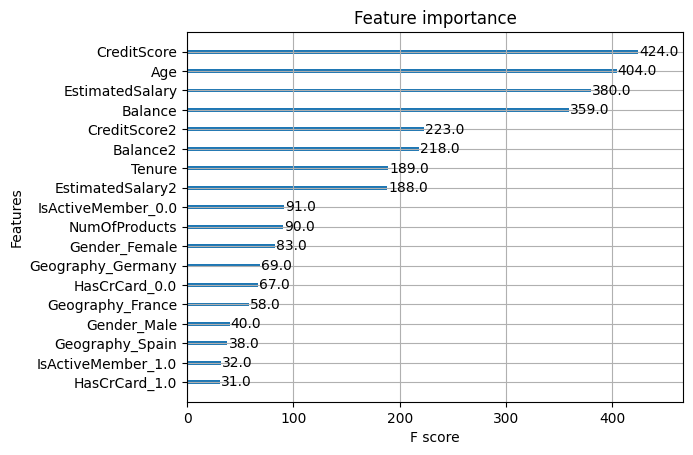

In [44]:
from xgboost import plot_importance
plot_importance(xgb_cv.best_estimator_)
plt.show()

# Prediction for the testing data

Now that we've selected our best model based on cross-validation on the training data, we can use that model to obtain predictions for the testing set.

In [15]:
# Add engineered features to testing data
test['EstimatedSalary2'] = test['EstimatedSalary']**2
test['CreditScore2'] = test['CreditScore']**2
test['Balance2'] = test['Balance']**2

# Next, we need to one hot encode the categorical variables in the testing data
X_test = test.drop(columns=['id', 'CustomerId','Surname'])

# Separate out the categorical columns for one hot encoding, apply one hot encoding
X_test_encoding = X_test[['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']]
X_test_encoded = encoder.transform(X_test_encoding)

# The encoded matrix is currently a numpy array. Change this to a data frame
X_test_encoded = pd.DataFrame(X_test_encoded, columns = encoder.get_feature_names_out())

# Combine the numerical columns with the categorical columns to create a single X_test data frame
X_test = pd.concat([X_test.drop(columns = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']).reset_index(drop = True), X_test_encoded], axis = 1)

# Make sure everything looks correct
X_test.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,EstimatedSalary2,CreditScore2,Balance2,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,HasCrCard_0.0,HasCrCard_1.0,IsActiveMember_0.0,IsActiveMember_1.0
0,586,23.0,2,0.00,2,160976.75,2.591351e+10,343396,0.000000e+00,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,683,46.0,2,0.00,1,72549.27,5.263397e+09,466489,0.000000e+00,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,656,34.0,7,0.00,2,138882.09,1.928823e+10,430336,0.000000e+00,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,681,36.0,8,0.00,1,113931.57,1.298040e+10,463761,0.000000e+00,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,752,38.0,10,121263.62,1,139431.00,1.944100e+10,565504,1.470487e+10,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


In [48]:
# Obtain predictions
final_predictions = pd.DataFrame(dict(id = test['id'],
                  Exited = xgb_cv.best_estimator_.predict_proba(X_test)[:, 1]))

# Look at the first few predictions
final_predictions.head()

,id,Exited
0,165034,0.023930
1,165035,0.835616
2,165036,0.028150
3,165037,0.232614
4,165038,0.338327


We now have our final predictions stored in the `final_predictions` dataframe. Now, we can save those results to a .csv file and submit them to Kaggle to obtain our final score.

In [31]:
# Save predictions to .csv
final_predictions.to_csv('churn_predictions.csv', index = False)

## Final Kaggle competition results

After submitting the predictions to Kaggle, a ROC AUC score on the testing data is returned.

According to Kaggle, the final ROC AUC score on the testing data of our model is 0.88864, or about 88.9%, which would have placed us in the top 38.7% of submissions during the competition (1406 place out of 3633 teams).

There are many additional things we could have done to improve model performance, such as:
* performing extensive feature engineering using domain expertise
* increasing grid search ranges for tuning model parameters
* making predictions with an ensemble model that combines output from our top models to produce a single prediction
* considering more complex models, such as neural networks (NN's)